<a href="https://colab.research.google.com/github/Voland24/AndrewNGDeepLearningCourse/blob/main/LogisticRegressionWithNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Logistic regression to recognize cats i.e. binary classifier**

In [7]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage


%matplotlib inline
    

In [8]:
def load_dataset():
    train_dataset = h5py.File("train_catvnoncat.h5", "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes
    
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

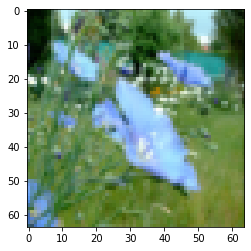

In [9]:
index = 20
plt.imshow(train_set_x_orig[index])

Just decribing our datasets

In [10]:
m_train = train_set_y.shape[1] 
m_test = test_set_y.shape[1]
num_px = train_set_x_orig.shape[1]


print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


Convert the test/train features i.e images from 4D tensor into 1D array i.e from (a,b,c,d) to (a*b*c*d)

In [15]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


Normalizing the dataset

In [12]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

Rule of thumb to remember, always see the dimensions of the data you are working with
It's common to reshape arrays from (a,b,c) to (a*b*c, 1), it's easier to work with
Standardize the data

In [16]:
def sigmoid(z):
  return (1 / (1 + np.exp(-z)))

#function used to treat outputs as P(class i | data)

In [17]:
def init_with_zeros(dim):
  w = np.zeros(shape = (dim,1))
  b = 0
  return w,b



Propagate function computes the cost function and it's gradient

In [18]:
def propagate(w, b, X, Y):
  """
  Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
  """


  m = X.shape[1]
  #forward pass
  A = sigmoid(np.dot(w.T, X) + b)
  cost =  (-1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))
  #back pass
  dw = (1/m) * np.dot(X, (A - Y).T)
  db = (1/m) * np.sum(A - Y)

  cost = np.squeeze(cost)

  grads = {"dw" : dw, "db" : db}

  return grads, cost

Now we will use gradient descent to optimize W and b parameters

In [23]:
def optimize(w, b, X, Y, num_iter, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """

    costs = []
    for i in range(num_iter):
      grads, cost = propagate(w, b, X, Y)
      dw = grads["dw"]
      db = grads["db"]

      w = w - learning_rate * dw
      b = b - learning_rate * db

      if i % 100 ==0:
        costs.append(cost)

      if print_cost and i % 100:
        print(f"Cost after iter no. {i}. = {cost}")

    params = {"w" : w, "b" : b}
    grads = {"dw" : dw, "db" : db}

    return params, grads,costs

Predict the class of the given image i.e output 0 or 1 using w and b learned via logistic regression

In [24]:
def predict(w,b,X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''


    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0],1)

    A = sigmoid(np.dot(w.T,X) + b)

    for i in range(A.shape[1]):
      Y_prediction[0,i] = 1 if A[0,i] > 0.5 else 0
    
    return Y_prediction



Putting all the functions into one model

In [25]:
def model(X_train, Y_train, X_test, Y_test, num_iter = 2000, learning_rate = 0.5, print_cost = True):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """

    w, b = init_with_zeros(X_train.shape[0])
    params, grads, costs = optimize(w,b,X_train, Y_train,num_iter,learning_rate, print_cost)

    w = params["w"]
    b = params["b"]

    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)

    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iter}

    return d


Training our model

In [26]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y,num_iter=2000,learning_rate=0.005, print_cost=True)

Cost after iter no. 1. = 0.7410294145065183
Cost after iter no. 2. = 0.7531535818862111
Cost after iter no. 3. = 0.8667086956701202
Cost after iter no. 4. = 0.7685635006608347
Cost after iter no. 5. = 0.897014473644793
Cost after iter no. 6. = 0.7556132280568213
Cost after iter no. 7. = 0.8804366426839868
Cost after iter no. 8. = 0.7514852682041282
Cost after iter no. 9. = 0.8771330533999597
Cost after iter no. 10. = 0.7449403578103343
Cost after iter no. 11. = 0.869479030571014
Cost after iter no. 12. = 0.7395380761496434
Cost after iter no. 13. = 0.8631813827864872
Cost after iter no. 14. = 0.7341140373099903
Cost after iter no. 15. = 0.8564988745006686
Cost after iter no. 16. = 0.7289883166665418
Cost after iter no. 17. = 0.8499947121719623
Cost after iter no. 18. = 0.7240300591410962
Cost after iter no. 19. = 0.843519150240876
Cost after iter no. 20. = 0.7192489303106331
Cost after iter no. 21. = 0.8371297668639591
Cost after iter no. 22. = 0.7146178461453454
Cost after iter no. 23